In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy


from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

import pymorphy3
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from scipy.stats import zscore
from keras.layers import LSTM, Embedding, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import Sequential
from keras.models import save_model, load_model
from wordcloud import WordCloud,STOPWORDS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
# https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
# https://www.kaggle.com/datasets/shubh0799/fake-news
# https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification?select=tom_and_jerry

In [3]:
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def url_extract(text):
    return re.sub(r'http\S+', '', text)

def stopwords(text):
    final_text = []
    for i in text.split():
        #checking in stopwords and also lowering the text
        if i.strip().lower() not in STOPWORDS:
            final_text.append(i.strip())
    return " ".join(final_text)

#finally getting all outputs in preprocessing the text using above functions
def preprocess(text):
    text = strip_html(text)
    text = square_brackets(text)
    text = url_extract(text)
    text = stopwords(text)
    return text

In [4]:
def print_history(history):
    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Точність навчання', 'Точність валідації'])
    plt.title('Точність навчання та валідації')
    plt.xlabel('Номер епохи')
    plt.ylabel('Точність')

    fig.add_subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Втрати при навчанні', 'Втрати при валідації'])
    plt.title('Втрати при навчанні та валідації')
    plt.xlabel('Номер епохи')
    plt.ylabel('Втрати')
    plt.show()

In [5]:
class iModel:
    def __init__(self):
        self.num_words = 10000
        self.max_article_length = 750
    

    def model_create_text(self):
        #
        model = Sequential()
        model.add(Embedding(input_dim=self.num_words, output_dim=64, input_length=self.max_article_length))
        model.add(LSTM(units=64))
        model.add(Dense(5, activation='sigmoid'))
        return model
    

    def model_create_text2(self):
        #
        model = Sequential()
        model.add(Embedding(input_dim=self.num_words, output_dim=64, input_length=self.max_article_length))
        model.add(LSTM(units=64, return_sequences=True))
        model.add(LSTM(units=64))
        model.add(Dense(5, activation='sigmoid'))
        return model

    def model_create_heart(self):
        #
        model = Sequential()
        model.add(Dense(32, input_dim=17,  activation='sigmoid'))
        model.add(Dense(128,  activation='sigmoid'))
        model.add(Dense(6, activation='sigmoid'))
        return model

    def model_compile(self, model):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


    def train_model(self, model, train_x, train_y, ep):
        history = model.fit(train_x, train_y, epochs=ep, validation_split=0.2)
        fig = plt.figure(figsize=(15,4))
        print_history(history)

    def model_evaluate(self, model, test_x, test_y):
        results = model.evaluate(test_x, test_y)
        print(results)


In [6]:
m = iModel()

In [7]:
def load_heart():
    df = pd.read_csv("heart_2020_cleaned.csv")
    numerical = df.select_dtypes(exclude='object')
    n = len(numerical)
    num_cols = df.select_dtypes(exclude='object').columns
    for col in numerical:
        Q1, Q3 = df[col].quantile([0.25,0.75])
        IQR = Q3 - Q1
        right = Q3 + 1.5 * IQR
        left = Q1 - 1.5 * IQR
        n = len(df.loc[(df[col] < left) | (df[col] > right)])
        print(f"{col}:\n\tOutlier Num = {n}\n\tOutlier Percentage = {n*100/len(df):.2f}%\n")
    zs = df.copy()
    for col in num_cols:
        zs[col] = zscore(zs[col])
    outscores = np.abs(zs[num_cols])
    no_outliers = (outscores<=3.3).all(axis=1)
    df = df[no_outliers]
    label_encoder = LabelEncoder()
    categorical_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity','Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'Race']
    for feature in categorical_features:
        print(df[feature].unique())
        df[feature]=label_encoder.fit_transform(df[feature])
        print(df[feature].unique())

    df['AgeCategory'] = df['AgeCategory'].replace({'18-24':0, '25-29':1, '30-34':2, '35-39':3, '40-44':4, '45-49':5, '50-54':6, '55-59':7, '60-64':8, '65-69':9, '70-74':10, '75-79':11, '80 or older':12})

    df['GenHealth'] = df['GenHealth'].replace({'Poor':0, 'Fair':1, 'Good':2, 'Very good':3, 'Excellent':4})

    df['Diabetic'] = df['Diabetic'].replace({'No':0, 'No, borderline diabetes':1, 'Yes (during pregnancy)':2, 'Yes':3})
    return df

1

In [8]:
df = load_heart()

BMI:
	Outlier Num = 10396
	Outlier Percentage = 3.25%

PhysicalHealth:
	Outlier Num = 47146
	Outlier Percentage = 14.74%

MentalHealth:
	Outlier Num = 51576
	Outlier Percentage = 16.13%

SleepTime:
	Outlier Num = 4543
	Outlier Percentage = 1.42%

['No' 'Yes']
[0 1]
['Yes' 'No']
[1 0]
['No' 'Yes']
[0 1]
['No' 'Yes']
[0 1]
['No' 'Yes']
[0 1]
['Yes' 'No']
[1 0]
['Yes' 'No']
[1 0]
['No' 'Yes']
[0 1]
['Yes' 'No']
[1 0]
['Female' 'Male']
[0 1]
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
[5 2 1 0 4 3]


In [9]:

names = df.columns
# df = pd.DataFrame(preprocessing.normalize(df, axis=0), columns=names) # 0.9237
x = df.drop('HeartDisease', axis=1)
# scaler = MinMaxScaler()
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = df['HeartDisease']


In [10]:
heart = m.model_create_heart()
m.model_compile(heart)
heart.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.5, random_state = 0)

Epoch 1/30


C:\Users\ANDB007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


3680/3680 [==============================] - 4s 863us/step - loss: 0.2200 - accuracy: 0.9246 - val_loss: 0.2214 - val_accuracy: 0.9238
Epoch 2/30
3680/3680 [==============================] - 3s 821us/step - loss: 0.2093 - accuracy: 0.9254 - val_loss: 0.2115 - val_accuracy: 0.9242
Epoch 3/30
3680/3680 [==============================] - 3s 948us/step - loss: 0.2088 - accuracy: 0.9263 - val_loss: 0.2116 - val_accuracy: 0.9244
Epoch 4/30
3680/3680 [==============================] - 3s 855us/step - loss: 0.2086 - accuracy: 0.9263 - val_loss: 0.2108 - val_accuracy: 0.9241
Epoch 5/30
3680/3680 [==============================] - 3s 831us/step - loss: 0.2084 - accuracy: 0.9263 - val_loss: 0.2107 - val_accuracy: 0.9247
Epoch 6/30
3680/3680 [==============================] - 3s 857us/step - loss: 0.2080 - accuracy: 0.9263 - val_loss: 0.2132 - val_accuracy: 0.9247
Epoch 7/30
3680/3680 [==============================] - 3s 907us/step - loss: 0.2076 - accuracy: 0.9264 - val_loss: 0.2105 - val_accura

<Figure size 1500x400 with 0 Axes>

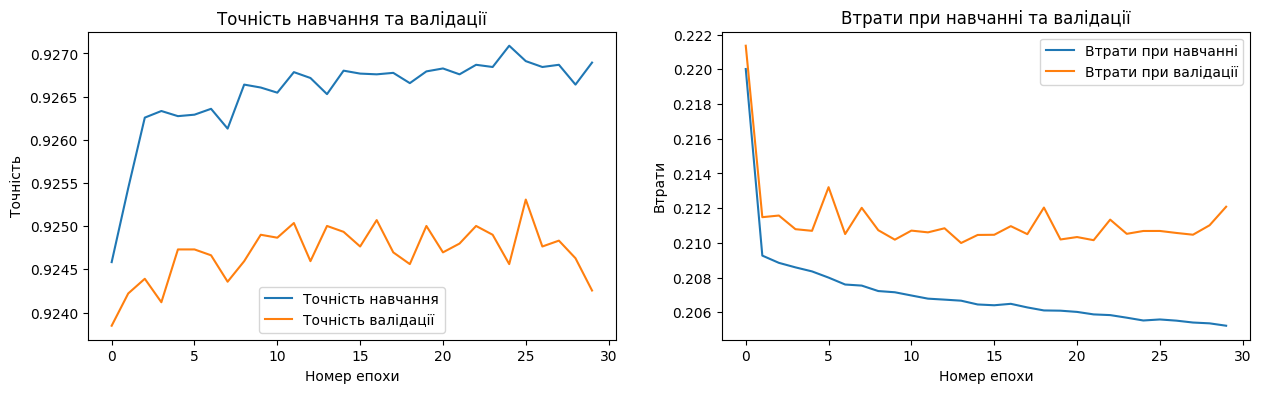

In [12]:
m.train_model(heart, X_train, Y_train, 30)

In [13]:
m.model_evaluate(heart, X_test, Y_test)

4601/4601 [==============================] - 3s 598us/step - loss: 0.2101 - accuracy: 0.9248
[0.21010702848434448, 0.9247763156890869]


2

In [14]:
IMAGE_DIRECTORY = "tom_and_jerry"

batch_size = 32
img_height = 72
img_width = 128

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGE_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGE_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


In [17]:
class_names = train_ds.class_names


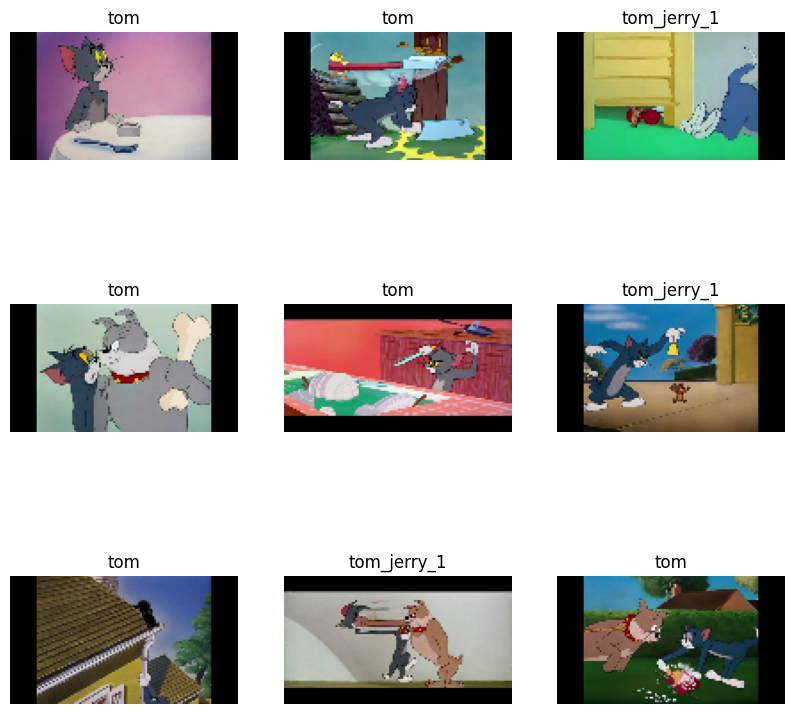

In [18]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 72, 128, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 72, 128, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 72, 128, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 32, 64)       

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
137/137 [==============================] - 57s 164ms/step - loss: 1.2777 - accuracy: 0.4116 - val_loss: 1.0979 - val_accuracy: 0.5461
Epoch 2/10
137/137 [==============================] - 15s 110ms/step - loss: 0.9811 - accuracy: 0.6067 - val_loss: 0.8433 - val_accuracy: 0.6676
Epoch 3/10
137/137 [==============================] - 15s 110ms/step - loss: 0.7519 - accuracy: 0.7150 - val_loss: 0.7408 - val_accuracy: 0.7352
Epoch 4/10
137/137 [==============================] - 16s 117ms/step - loss: 0.5491 - accuracy: 0.8026 - val_loss: 0.6139 - val_accuracy: 0.7863
Epoch 5/10
137/137 [==============================] - 15s 113ms/step - loss: 0.4085 - accuracy: 0.8476 - val_loss: 0.5650 - val_accuracy: 0.7982
Epoch 6/10
137/137 [==============================] - 15s 113ms/step - loss: 0.3044 - accuracy: 0.8852 - val_loss: 0.5829 - val_accuracy: 0.7890
Epoch 7/10
137/137 [==============================] - 16s 115ms/step - loss: 0.2482 - accuracy: 0.9094 - val_loss: 0.5746 - val_ac

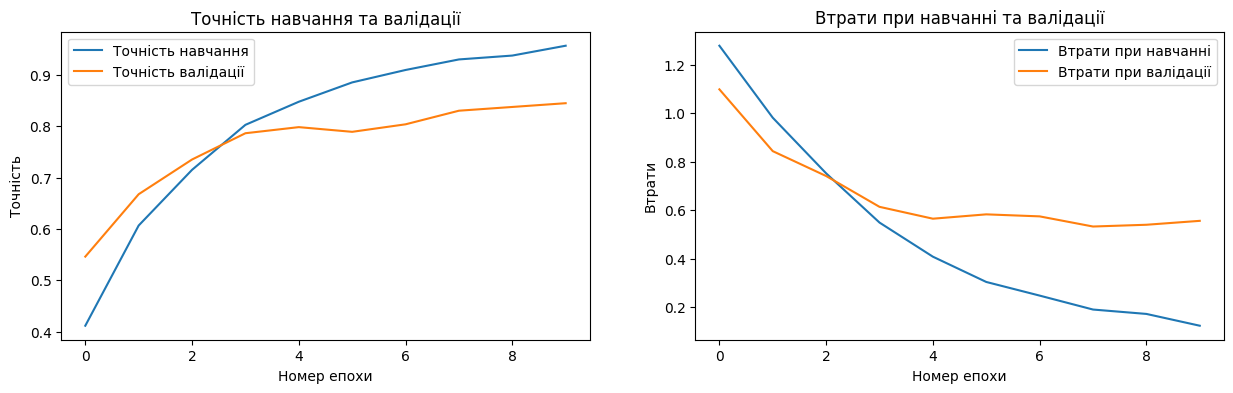

In [26]:
print_history(history)

In [27]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 72, 128, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 128, 16)       448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 36, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 32, 64)       

In [28]:

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
137/137 [==============================] - 16s 115ms/step - loss: 1.2104 - accuracy: 0.4529 - val_loss: 1.0243 - val_accuracy: 0.5881
Epoch 2/15
137/137 [==============================] - 16s 114ms/step - loss: 0.8516 - accuracy: 0.6610 - val_loss: 0.6816 - val_accuracy: 0.7388
Epoch 3/15
137/137 [==============================] - 15s 111ms/step - loss: 0.5869 - accuracy: 0.7796 - val_loss: 0.5872 - val_accuracy: 0.7854
Epoch 4/15
137/137 [==============================] - 15s 113ms/step - loss: 0.4401 - accuracy: 0.8303 - val_loss: 0.5245 - val_accuracy: 0.8082
Epoch 5/15
137/137 [==============================] - 16s 115ms/step - loss: 0.3481 - accuracy: 0.8677 - val_loss: 0.5086 - val_accuracy: 0.8046
Epoch 6/15
137/137 [==============================] - 16s 116ms/step - loss: 0.2622 - accuracy: 0.9005 - val_loss: 0.5107 - val_accuracy: 0.8247
Epoch 7/15
137/137 [==============================] - 16s 116ms/step - loss: 0.2134 - accuracy: 0.9208 - val_loss: 0.4562 - val_ac

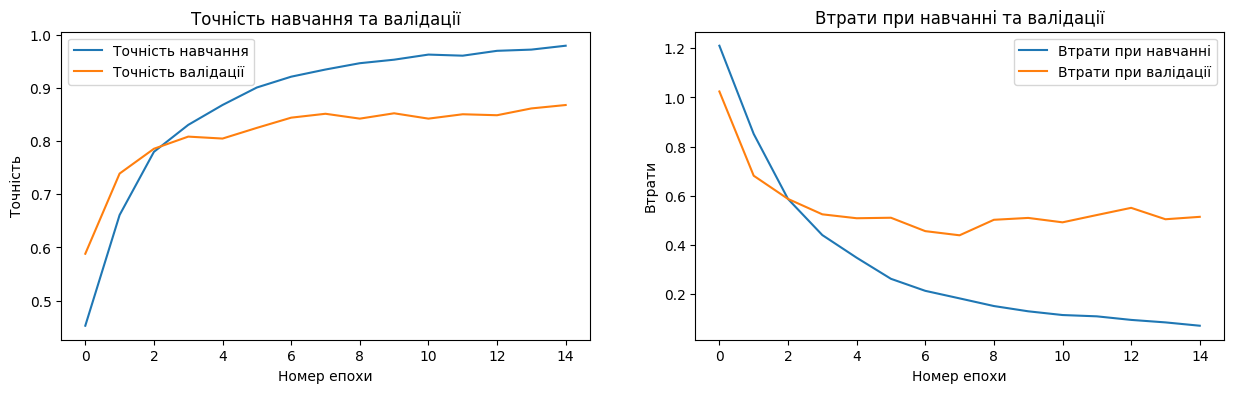

In [29]:
print_history(history)

3

In [30]:
df = pd.read_csv('news.csv')

In [31]:
df['label'] = df['label'].replace('FAKE', 0)
df['label'] = df['label'].replace('REAL', 1)
df.drop('Unnamed: 0', axis =1 , inplace = True)

In [32]:
df['text'] = df['text'].apply(preprocess)

C:\Users\ANDB007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [51]:
def tokenize_text(data, max_article_length):
    num_words = 10000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(data['text'])
    x = tokenizer.texts_to_sequences(data['text'])
    x = pad_sequences(x, maxlen=max_article_length)
    return x

In [52]:
x = tokenize_text(df, 750)

y = df["label"]

In [53]:
text_model = m.model_create_text()
m.model_compile(text_model)
text_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 750, 64)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
Total params: 673,349
Trainable params: 673,349
Non-trainable params: 0
_________________________________________________________________


In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.5, random_state = 0)

Epoch 1/4
80/80 [==============================] - 14s 158ms/step - loss: 0.8428 - accuracy: 0.5401 - val_loss: 0.6701 - val_accuracy: 0.5079
Epoch 2/4
80/80 [==============================] - 12s 154ms/step - loss: 0.5028 - accuracy: 0.7773 - val_loss: 0.3676 - val_accuracy: 0.8265
Epoch 3/4
80/80 [==============================] - 12s 155ms/step - loss: 0.1642 - accuracy: 0.9447 - val_loss: 0.4060 - val_accuracy: 0.8249
Epoch 4/4
80/80 [==============================] - 13s 157ms/step - loss: 0.0525 - accuracy: 0.9866 - val_loss: 0.4931 - val_accuracy: 0.8312


<Figure size 1500x400 with 0 Axes>

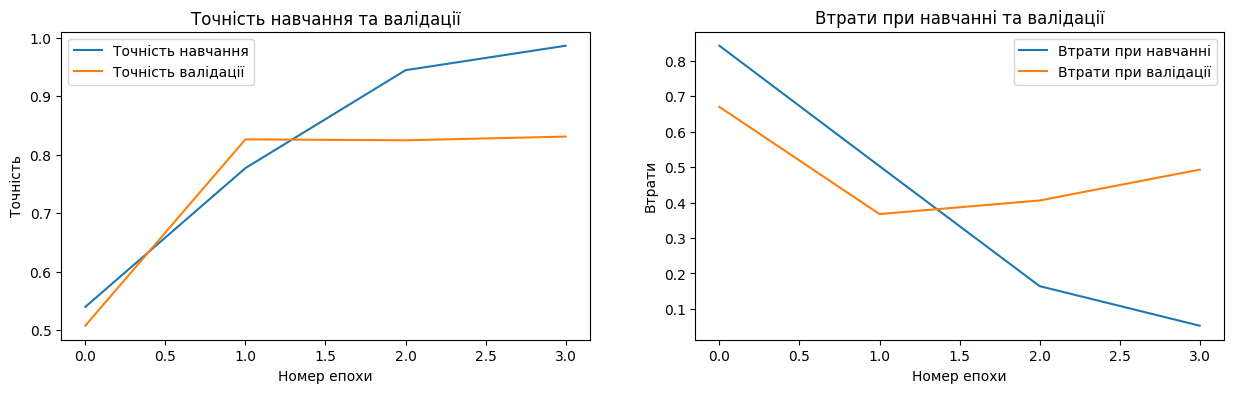

In [56]:
m.train_model(text_model, X_train, Y_train, 4)

In [57]:
m.model_evaluate(text_model, X_test, Y_test)

99/99 [==============================] - 5s 49ms/step - loss: 0.5061 - accuracy: 0.8201
[0.5060713887214661, 0.8200757503509521]


In [59]:
text_model2 = m.model_create_text2()
m.model_compile(text_model2)
text_model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 750, 64)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 750, 64)           33024     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 706,373
Trainable params: 706,373
Non-trainable params: 0
_________________________________________________________________


Epoch 1/4


C:\Users\ANDB007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


80/80 [==============================] - 28s 326ms/step - loss: 0.8318 - accuracy: 0.4939 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 2/4
80/80 [==============================] - 25s 319ms/step - loss: 0.6065 - accuracy: 0.6518 - val_loss: 0.4901 - val_accuracy: 0.7555
Epoch 3/4
80/80 [==============================] - 26s 323ms/step - loss: 0.2236 - accuracy: 0.9179 - val_loss: 0.4034 - val_accuracy: 0.8312
Epoch 4/4
80/80 [==============================] - 26s 325ms/step - loss: 0.0612 - accuracy: 0.9834 - val_loss: 0.4698 - val_accuracy: 0.8328


<Figure size 1500x400 with 0 Axes>

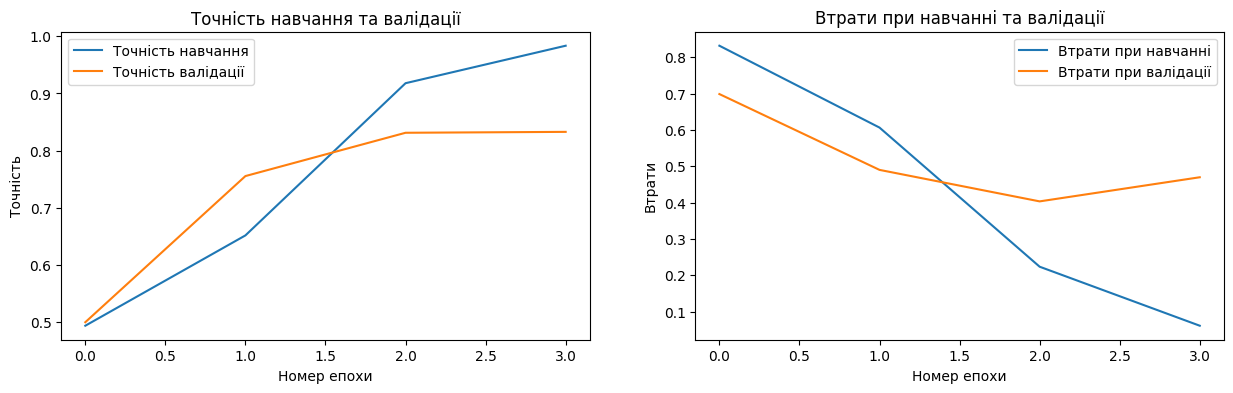

In [62]:
m.train_model(text_model2, X_train, Y_train, 4)

In [63]:
m.model_evaluate(text_model2, X_test, Y_test)

99/99 [==============================] - 9s 95ms/step - loss: 0.4874 - accuracy: 0.8355
[0.48740896582603455, 0.8355429172515869]
